# Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import pandas_profiling
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

# Загрузка данных. Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных.

In [2]:
data = pd.read_csv('credit.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
ID                  1000 non-null int64
Age                 1000 non-null int64
Sex                 1000 non-null object
Job                 1000 non-null int64
Housing             1000 non-null object
Saving accounts     817 non-null object
Checking account    606 non-null object
Credit amount       1000 non-null int64
Duration            1000 non-null int64
Purpose             1000 non-null object
Risk                1000 non-null object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


In [4]:
data.head()

,ID,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [5]:
data.shape

(1000, 11)

In [6]:
# Удаляем ID, переименовываем некоторые признаки
data.drop(['ID'], axis=1, inplace=True)
data.rename(columns={'Saving accounts': 'SavingAcc', 'Checking account': 'CheckingAcc', 
                     'Credit amount': 'CreditAmnt'}, inplace=True)



In [7]:
pandas_profiling.ProfileReport(data)

Number of variables,10
Number of observations,1000
Total Missing (%),5.8%
Total size in memory,78.2 KiB
Average record size in memory,80.1 B
Numeric,4
Categorical,6
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [8]:
plt.rcParams['figure.figsize']=(12,5)

### Построим графики распределения решения по кредиту для различных признаков

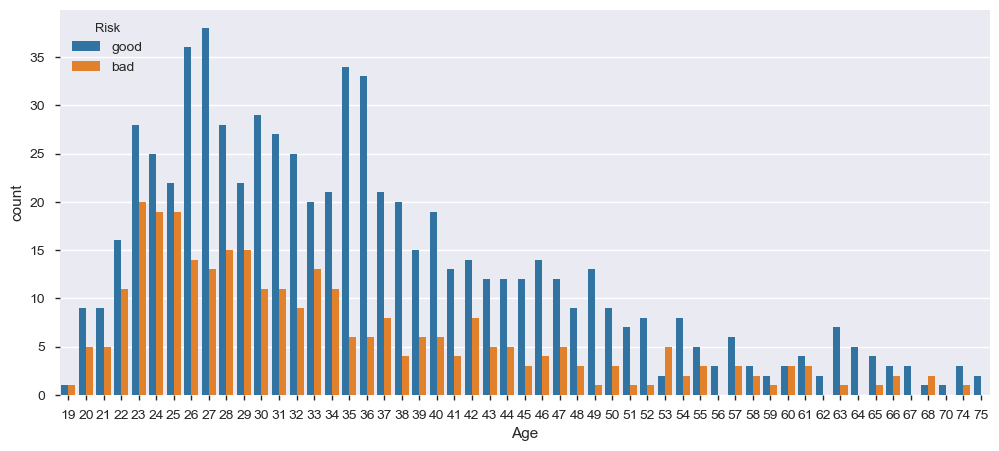

In [9]:
sns.countplot(x='Age', data=data, hue='Risk')

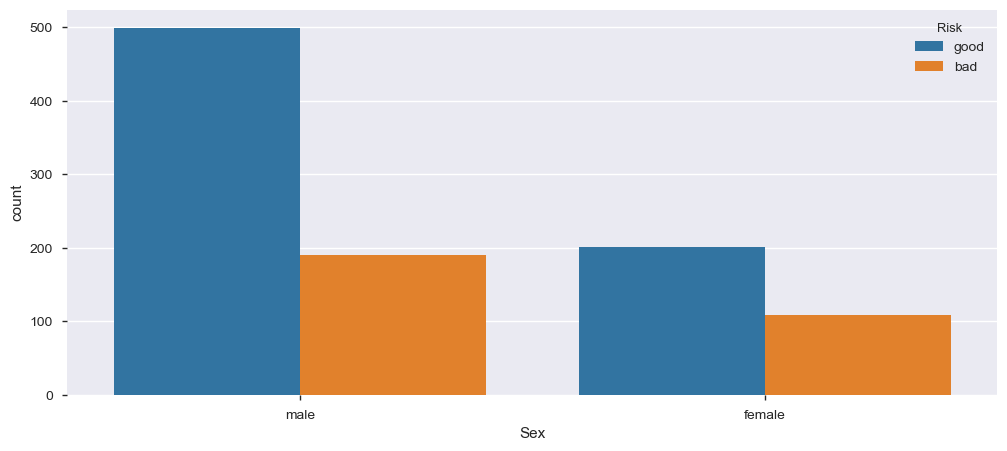

In [10]:
sns.countplot(x='Sex', data=data, hue='Risk')

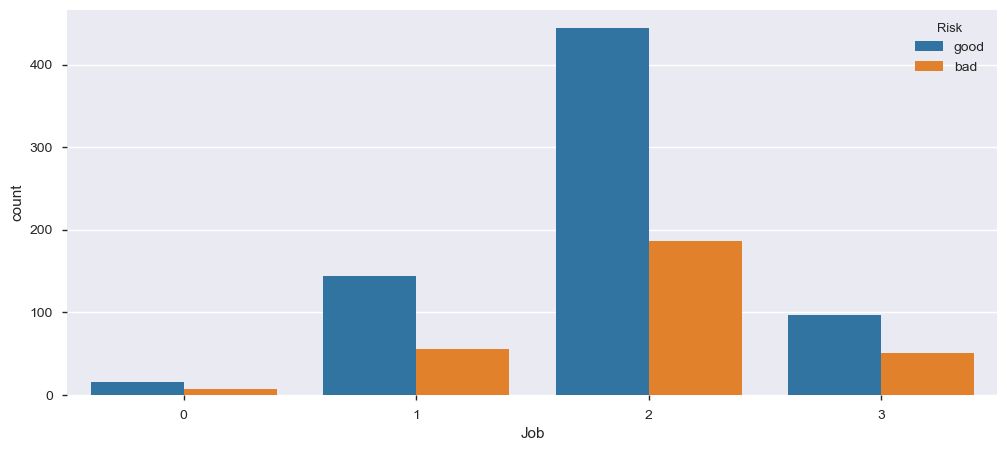

In [11]:
sns.countplot(x='Job', data=data, hue='Risk')

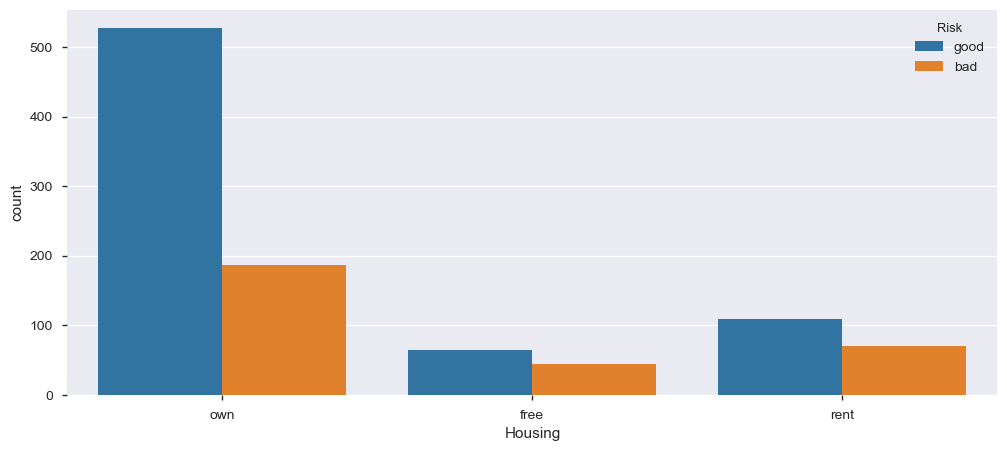

In [12]:
sns.countplot(x='Housing', data=data, hue='Risk')

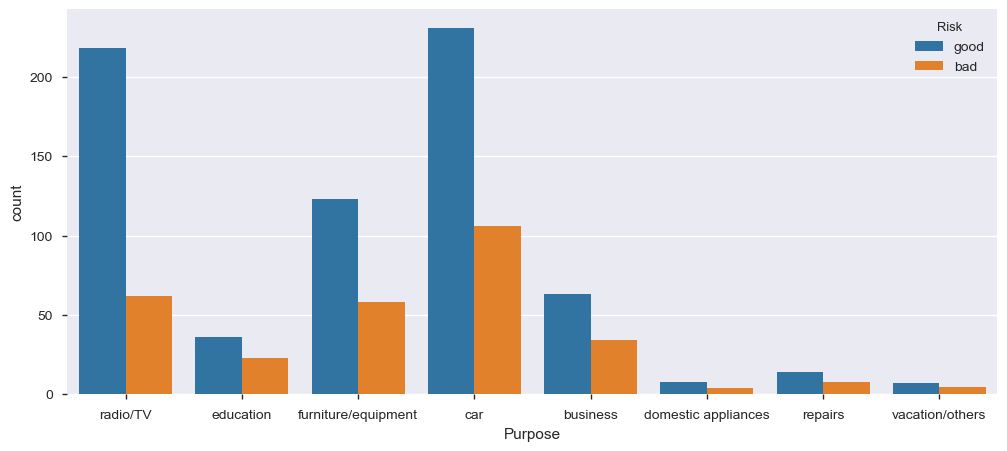

In [13]:
sns.countplot(x='Purpose', data=data, hue='Risk')

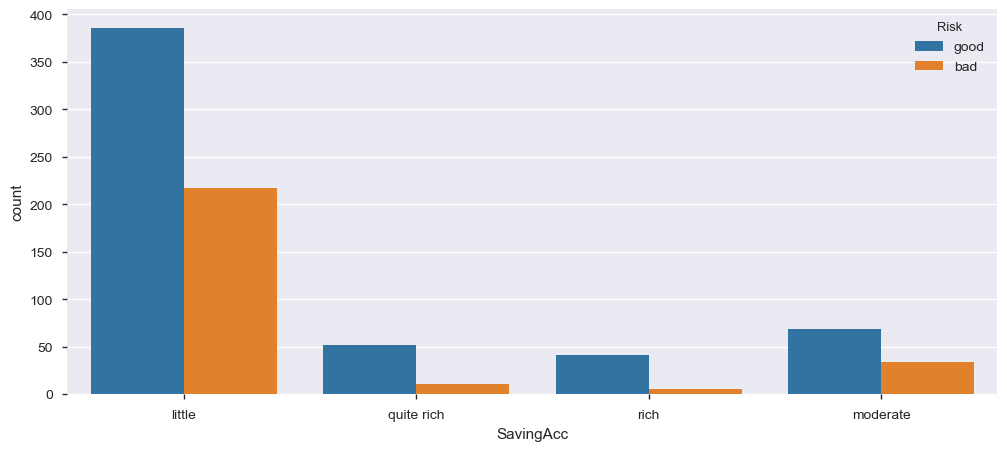

In [14]:
sns.countplot(x='SavingAcc', data=data, hue='Risk')

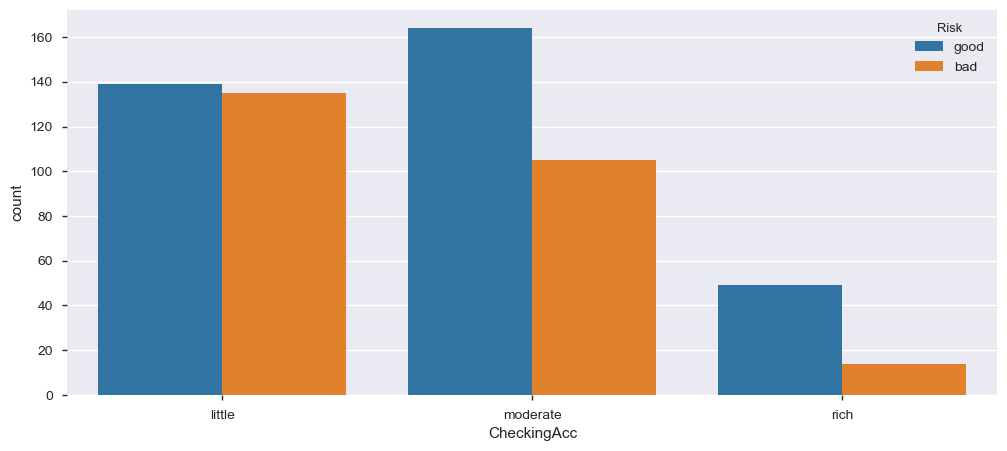

In [15]:
sns.countplot(x='CheckingAcc', data=data, hue='Risk')

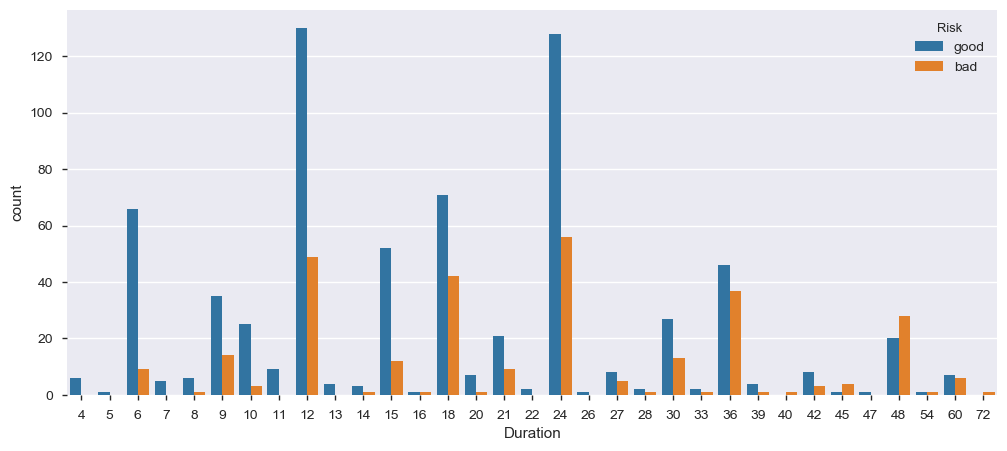

In [16]:
sns.countplot(x='Duration', data=data, hue='Risk')

In [17]:
# Соотношение выданные/невыданные по целям
crtab = pd.crosstab(data['Purpose'], data['Risk'])
crtab.good/crtab.bad

Purpose
business               1.852941
car                    2.179245
domestic appliances    2.000000
education              1.565217
furniture/equipment    2.120690
radio/TV               3.516129
repairs                1.750000
vacation/others        1.400000
dtype: float64

In [18]:
# Соотношение мужчины/женщины по целям
crtab = pd.crosstab(data['Purpose'], data['Sex'])
crtab.male/crtab.female

Purpose
business               4.105263
car                    2.585106
domestic appliances    1.000000
education              1.458333
furniture/equipment    1.445946
radio/TV               2.294118
repairs                3.400000
vacation/others        3.000000
dtype: float64

# Кодирование категориальных признаков, заполнение пропусков и масштабирование значений

In [19]:
# Заполняем пропуски на "NoInformation"
data['SavingAcc'] = data['SavingAcc'].fillna('NoInformation')
data['CheckingAcc'] = data['CheckingAcc'].fillna('NoInformation')

In [20]:
# Кодируем категориальные признаки 
data['IsMale']=data.Sex.replace({'female':0,'male':1})
data.drop(['Sex'], axis=1, inplace=True)
data['Purpose'].replace({'car':1, 'furniture/equipment':2, 'radio/TV':3, 'domestic appliances':4, 
                                         'repairs':5, 'education':6, 'business':7, 'vacation/others':8}, inplace=True)
data['GivеCredit?']=data['Risk'].replace({'bad':0,'good':1})
data.drop(['Risk'], axis=1, inplace=True)

In [21]:
# Разбиваем категориальные признаки с получением столбцов-флагов для обозначения строк с пропущенными значениями
data = pd.get_dummies(data, columns=['SavingAcc','Housing','Job','CheckingAcc'])

In [22]:
data.columns

Index(['Age', 'CreditAmnt', 'Duration', 'Purpose', 'IsMale', 'GivеCredit?',
       'SavingAcc_NoInformation', 'SavingAcc_little', 'SavingAcc_moderate',
       'SavingAcc_quite rich', 'SavingAcc_rich', 'Housing_free', 'Housing_own',
       'Housing_rent', 'Job_0', 'Job_1', 'Job_2', 'Job_3',
       'CheckingAcc_NoInformation', 'CheckingAcc_little',
       'CheckingAcc_moderate', 'CheckingAcc_rich'],
      dtype='object')

In [23]:
# Масштабируем некоторые признаки
sc2 = StandardScaler()
data[['Age','CreditAmnt','Duration','Purpose']] = sc2.fit_transform(data[['Age','CreditAmnt','Duration','Purpose']])
data

,Age,CreditAmnt,Duration,Purpose,IsMale,GivеCredit?,SavingAcc_NoInformation,SavingAcc_little,SavingAcc_moderate,SavingAcc_quite rich,...,Housing_own,Housing_rent,Job_0,Job_1,Job_2,Job_3,CheckingAcc_NoInformation,CheckingAcc_little,CheckingAcc_moderate,CheckingAcc_rich
0,2.766456,-0.745131,-1.236478,0.087199,1,1,1,0,0,0,...,1,0,0,0,1,0,0,1,0,0
1,-1.191404,0.949817,2.248194,0.087199,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,1,0
2,1.183312,-0.416562,-0.738668,1.590638,1,1,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0
3,0.831502,1.634247,1.750384,-0.413947,1,1,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
4,1.535122,0.566664,0.256953,-0.915093,1,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-0.399832,-0.544162,-0.738668,-0.413947,0,1,0,1,0,0,...,1,0,0,1,0,0,1,0,0,0
996,0.391740,0.207612,0.754763,-0.915093,1,1,0,1,0,0,...,1,0,0,0,0,1,0,1,0,0
997,0.215835,-0.874503,-0.738668,0.087199,1,1,0,1,0,0,...,1,0,0,0,1,0,1,0,0,0
998,-1.103451,-0.505528,1.999289,0.087199,1,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0


# Корреляционный анализ

In [24]:
corr_matrix = data.corr()
corr_matrix['GivеCredit?']

Age                          0.091127
CreditAmnt                  -0.154739
Duration                    -0.214927
Purpose                     -0.035214
IsMale                       0.075493
GivеCredit?                  1.000000
SavingAcc_NoInformation      0.129238
SavingAcc_little            -0.161007
SavingAcc_moderate          -0.022255
SavingAcc_quite rich         0.070954
SavingAcc_rich               0.085749
Housing_free                -0.081556
Housing_own                  0.134589
Housing_rent                -0.092785
Job_0                       -0.005951
Job_1                        0.021822
Job_2                        0.013559
Job_3                       -0.040559
CheckingAcc_NoInformation    0.322436
CheckingAcc_little          -0.258333
CheckingAcc_moderate        -0.119581
CheckingAcc_rich             0.044009
Name: GivеCredit?, dtype: float64

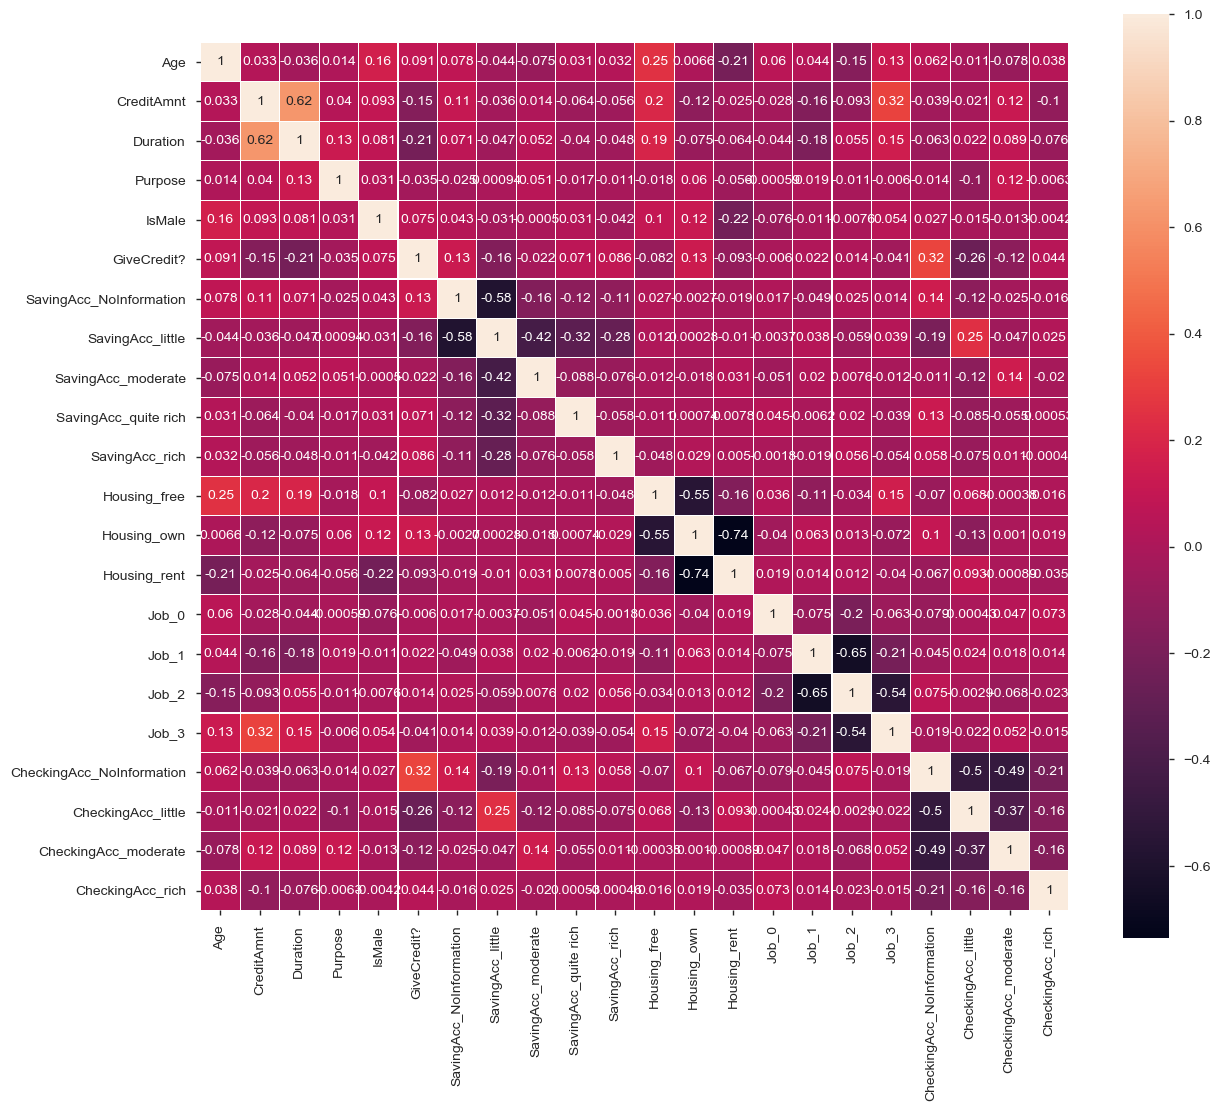

In [25]:
plt.figure(figsize=(14,12))
sns.heatmap(data.corr(),linewidths=0.1,vmax=1.0, 
            square=True,  linecolor='white', annot=True)
plt.show()

# Выбор метрик

Используем метрики качества, подходящие для задач классификации - precision, recall и f1-score. 

In [26]:
# Класс для сохранения метрик и их визуализации
class MetricLogger:
    
    def __init__(self):
        self.df = pd.DataFrame(
            {'metric': pd.Series([], dtype='str'),
            'alg': pd.Series([], dtype='str'),
            'value': pd.Series([], dtype='float')})

    def add(self, metric, alg, value):
        """
        Добавление значения
        """
        # Удаление значения если оно уже было ранее добавлено
        self.df.drop(self.df[(self.df['metric']==metric)&(self.df['alg']==alg)].index, inplace = True)
        # Добавление нового значения
        temp = [{'metric':metric, 'alg':alg, 'value':value}]
        self.df = self.df.append(temp, ignore_index=True)

    def get_data_for_metric(self, metric, ascending=True):
        """
        Формирование данных с фильтром по метрике
        """
        temp_data = self.df[self.df['metric']==metric]
        temp_data_2 = temp_data.sort_values(by='value', ascending=ascending)
        return temp_data_2['alg'].values, temp_data_2['value'].values
    
    def plot(self, str_header, metric, ascending=True, figsize=(5, 5)):
        """
        Вывод графика
        """
        array_labels, array_metric = self.get_data_for_metric(metric, ascending)
        fig, ax1 = plt.subplots(figsize=figsize)
        pos = np.arange(len(array_metric))
        rects = ax1.barh(pos, array_metric,
                         align='center',
                         height=0.5, 
                         tick_label=array_labels)
        ax1.set_title(str_header)
        for a,b in zip(pos, array_metric):
            plt.text(0.5, a-0.05, str(round(b,3)), color='white')
        plt.show()  

# Выбор моделей

Будем использовать следующие модели:
* Логистическая регрессия
* Метод ближайших соседей
* Дерево решений
* Случайный лес
* Градиентный бустинг

# Формирование выборок

In [27]:
# Сохраняем целевой признак
y = data['GivеCredit?']
data.drop('GivеCredit?', axis=1, inplace=True)

In [28]:
y = y.astype('int')

In [29]:
# Разбиваем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.30, random_state=1)

# Построение базовых решений

In [30]:
# Словарь с моделями
clas_models = {'LR': LogisticRegression(random_state = 1), 
               'KNN_5':KNeighborsClassifier(n_neighbors=5),
               'DT':DecisionTreeClassifier(random_state = 1),
               'RF':RandomForestClassifier(random_state = 1),
               'GB':GradientBoostingClassifier(random_state = 1)}

In [31]:
# Функция для обучения моделей и расчета метрик качества
def clas_train_model(model_name, model, clasMetricLogger):
    md = model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)
    precision = precision_score(y_test, Y_pred)
    recall = recall_score(y_test, Y_pred)
    f1 = f1_score(y_test, Y_pred)
    print(md)
    clasMetricLogger.add('precision', model_name, precision)
    clasMetricLogger.add('recall', model_name, recall)
    clasMetricLogger.add('f1', model_name, f1)

In [32]:
# Сохранение метрик
clasMetricLogger = MetricLogger()

In [33]:
# Обучение моделей
for model_name, model in clas_models.items():
    clas_train_model(model_name, model, clasMetricLogger)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight

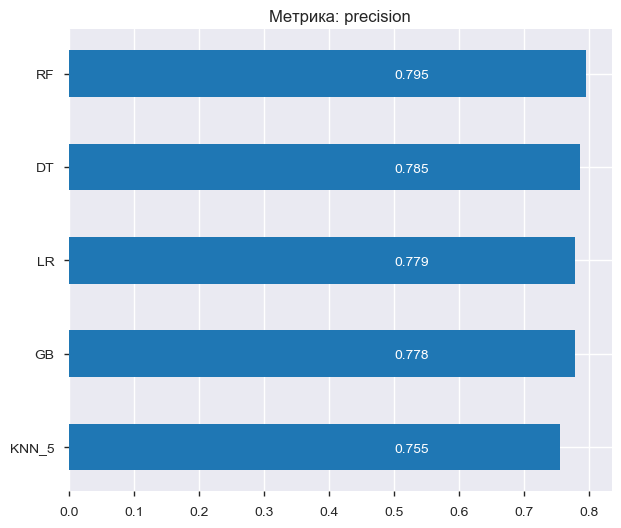

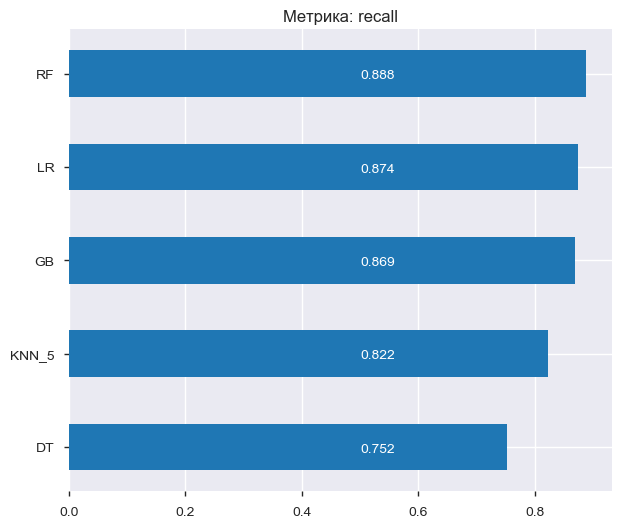

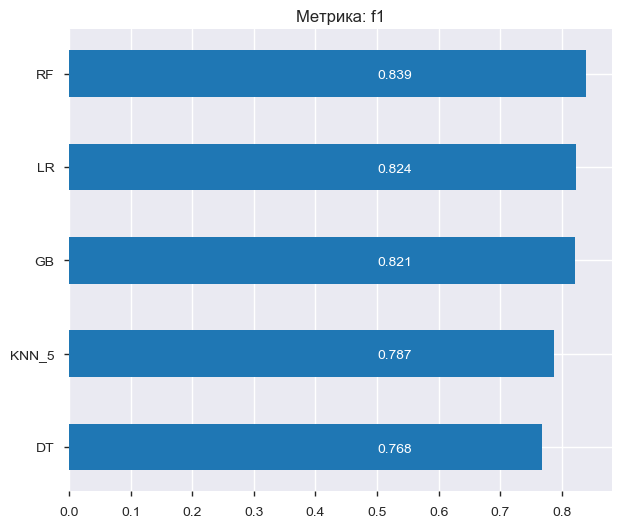

In [34]:
# Визуализация метрик 
clas_metrics = clasMetricLogger.df['metric'].unique()
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 6))

# Подбор гиперпараметров

## LR

In [35]:
grid={
    'C':np.logspace(-4,4,9),
    'penalty':["l1","l2"],
    'random_state': [1]
    }
LRalg=LogisticRegression()
LR_cv=GridSearchCV(LRalg,grid,cv=5, scoring='recall_weighted')
LR_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03,
       1.e+04]),
                         'penalty': ['l1', 'l2'], 'random_state': [1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall_weighted', verbose=0)

In [36]:
#Словарь для сохранения моделей
clas_models_grid={}

In [37]:
clas_models_grid['LR_cv'] = LR_cv.best_estimator_

## KNN

In [38]:
grid={
    'n_neighbors': list(range(5,200,5)),
     }
KNNalg=KNeighborsClassifier()
KNN_cv=GridSearchCV(KNNalg,grid, cv=5, scoring='recall_weighted')
KNN_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50,
                                         55, 60, 65, 70, 75, 80, 85, 90, 95,
                                         100, 105, 110, 115, 120, 125, 130, 135,
                                         140, 145, 150, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall_weighted', verbose=0)

In [39]:
clas_models_grid['KNN_cv']=KNN_cv.best_estimator_

## DT

In [40]:
grid={
    'max_leaf_nodes': list(range(2, 100)), 
    'min_samples_split': [2, 3, 4],
    'random_state'      : [1]
}

In [41]:
DTalg=DecisionTreeClassifier()
DT_cv=GridSearchCV(DTalg,grid,cv=5, scoring='recall_weighted')
DT_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12

In [42]:
clas_models_grid['DT_cv'] = DT_cv.best_estimator_

## RF

In [43]:
grid={
    'n_estimators'      : list(range(100,300,50)),
    'random_state'      : [1]
    }

In [44]:
RFalg=RandomForestClassifier()
RF_cv=GridSearchCV(RFalg,grid,cv=5, scoring='recall_weighted')
RF_cv.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [45]:
clas_models_grid['RF_cv'] = RF_cv.best_estimator_

# Вывод о качестве полученных моделей

In [46]:
for model_name, model in clas_models_grid.items():
    clas_train_model(model_name, model, clasMetricLogger)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=11,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weigh

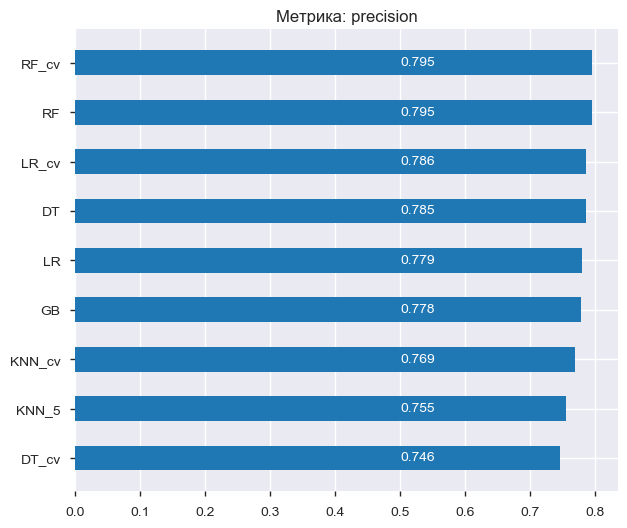

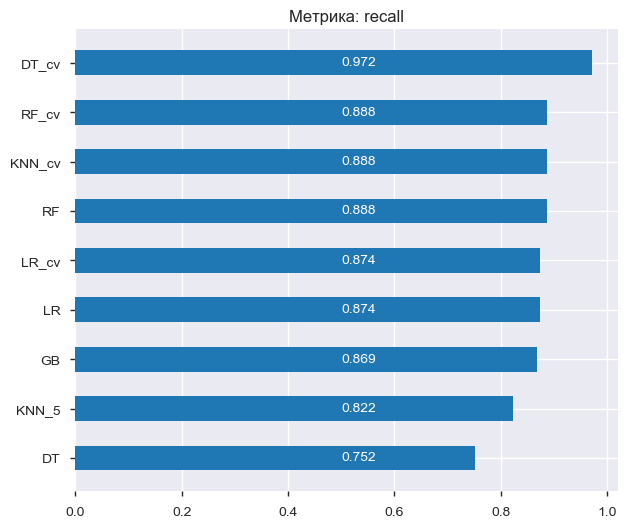

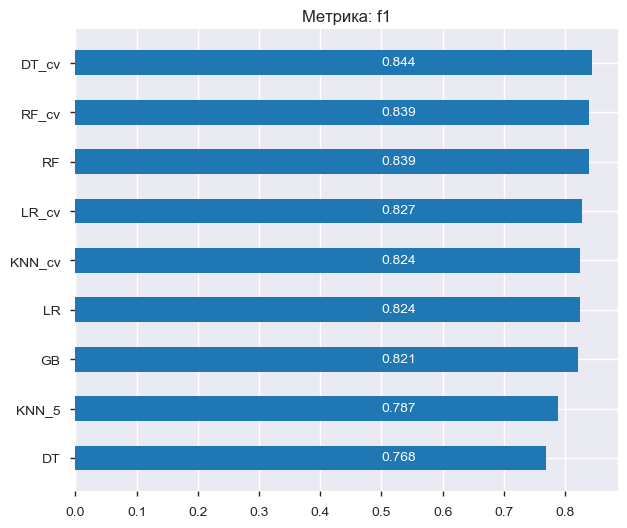

In [47]:
clas_metrics = clasMetricLogger.df['metric'].unique()
for metric in clas_metrics:
    clasMetricLogger.plot('Метрика: ' + metric, metric, figsize=(7, 6))

## Вывод: модели случайного леса и дерева решений с подобранными гиперпараметрами оказались лучшими. 